**Using ADALINE for Binary Classification**
Katie Bernard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from adaline import Adaline

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=3)
%load_ext autoreload
%autoreload 2

In [2]:
net = Adaline()

Processing Old Faithful data with ADALINE

    Waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

    Variables:
    ----------
    sample     numeric      Measurement number
    eruptions  numeric      Eruption time in mins
    waiting    numeric      Waiting time to next eruption
    severe     categorical  Whether the eruption was "severe"
                            (+1: severe, -1 not severe)

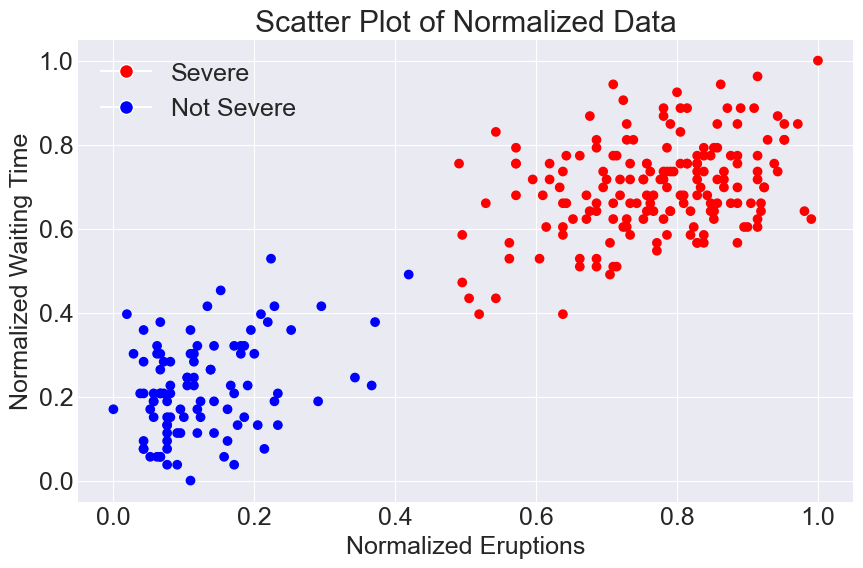

In [3]:
data = pd.read_csv('old_faithful.csv')
features = data[['eruptions', 'waiting']]
features = features.to_numpy()

output_classes = data['severe']
output_classes = output_classes.to_numpy()

#preprocess data ==> min-max normalization across features
min = features.min(axis=0)
max = features.max(axis=0)
normalized_features = (features - min) / (max - min)


plt.figure(figsize=(10, 6))
color_map = np.where(output_classes == 1, 'red', 'blue')
plt.scatter(normalized_features[:, 0], normalized_features[:, 1], c=color_map)
plt.title('Scatter Plot of Normalized Data')
plt.xlabel('Normalized Eruptions')
plt.ylabel('Normalized Waiting Time')

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Severe'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Not Severe')],
           loc='best')
plt.grid(True)
plt.show()



In [4]:
rng = np.random.default_rng(1)
adaline = Adaline()
inputs = normalized_features
y = output_classes
loss, acc = adaline.fit(inputs, y, r_seed=0)
print("final loss: ", loss[-1])
print("final accuracy: ", acc[-1]*100,"%")

final loss:  11.355911469708227
final accuracy:  100.0 %


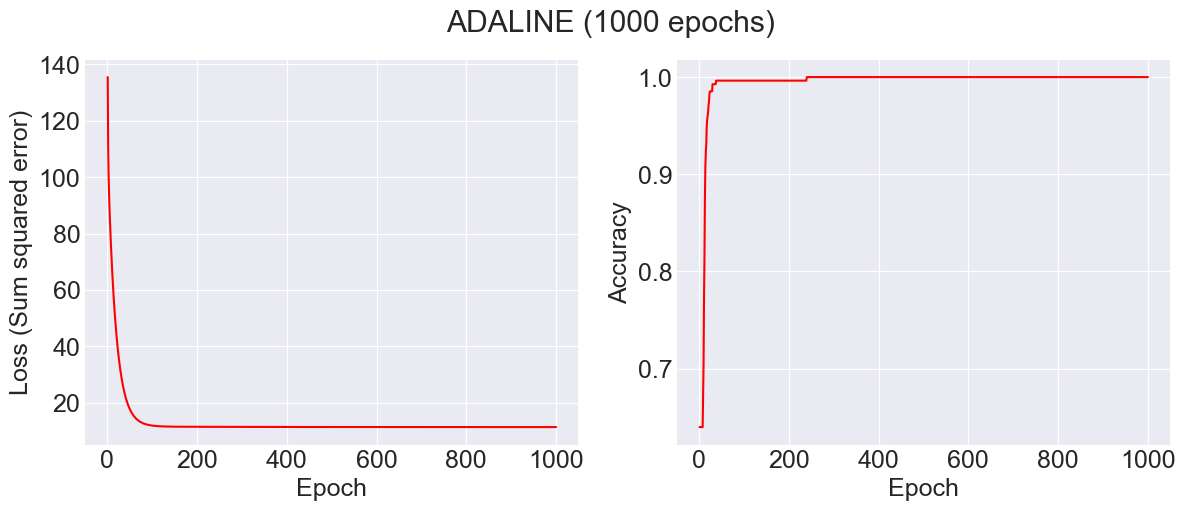

In [5]:
def plot_adaline_train(net, loss_list, acc_list, plotMarkers=False, title='ADALINE'):
    n_epochs = len(loss_list)

    x = np.arange(1, n_epochs+1)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f'{title} ({n_epochs} epochs)')

    curveStr = '-r'
    if plotMarkers:
        curveStr += 'o'

    ax1.plot(x, loss_list, curveStr)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Sum squared error)')
    ax2.plot(x, acc_list, curveStr)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    plt.show()

plot_adaline_train(adaline, loss, acc)

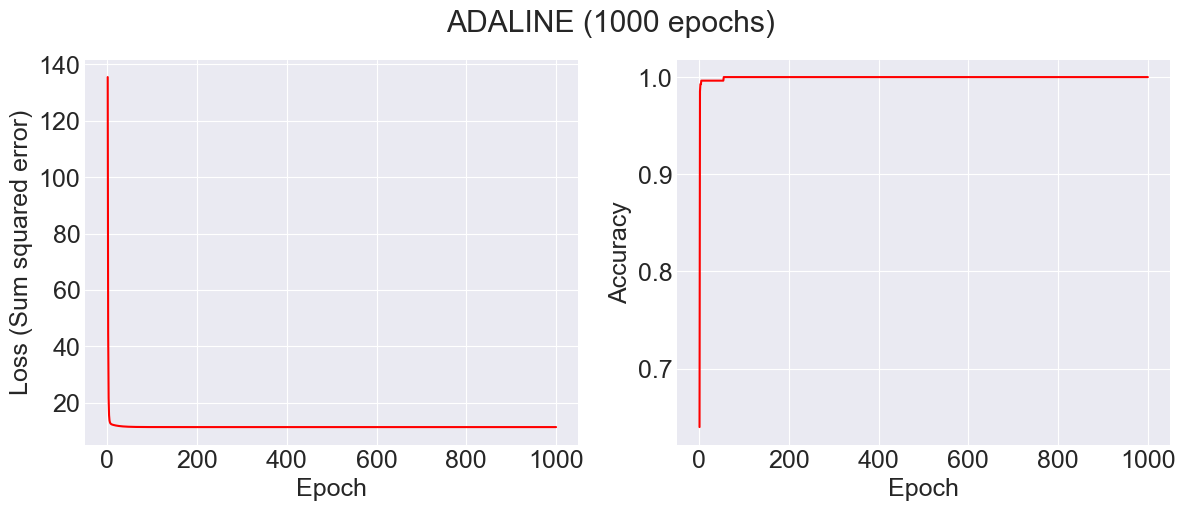

In [6]:
#standardizing the features
means = features.mean(axis=0)
stdevs = features.std(axis=0)
standardized_features = (features - means) / stdevs

#fit
adaline_standardized = Adaline()
losses, accs = adaline_standardized.fit(standardized_features, y, r_seed=0)

plot_adaline_train(adaline_standardized,  losses, accs)

C:\Users\katie\AppData\Local\Temp\ipykernel_33468\922470187.py:19: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 50)  # Adjust to focus on the range of loss where differences appear


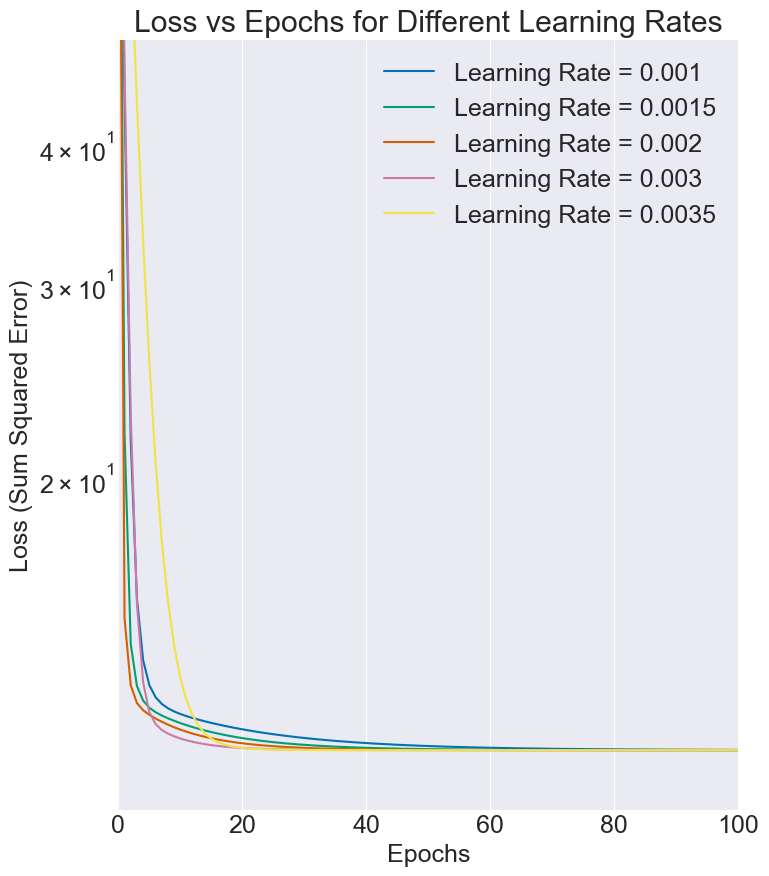

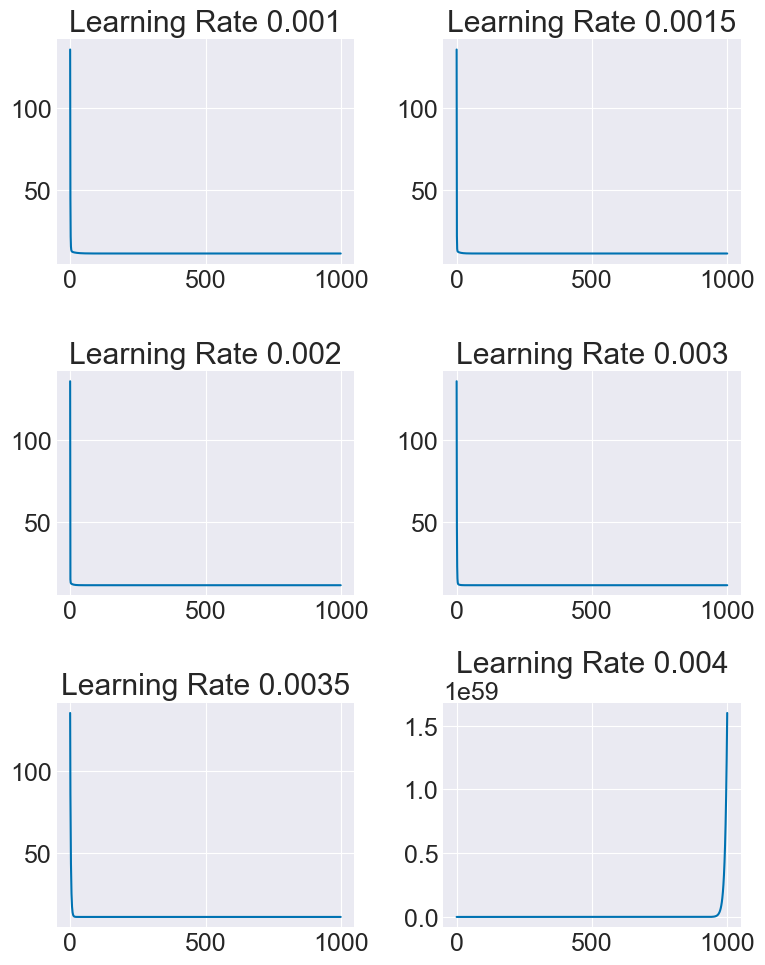

In [7]:
learning_rates = [0.001, 0.0015, 0.002, 0.003, 0.0035, 0.004]
results = {} # dictionary for data

#fit / get data
for lr in learning_rates:
    adaline_standardized = Adaline()
    losses, accs = adaline_standardized.fit(standardized_features, y, lr=lr, r_seed=0)
    results[lr] = losses

plt.figure(figsize=(8,10))
for lr in learning_rates[:5]:
    plt.plot(results[lr], label=f'Learning Rate = {lr}')
plt.yscale('log')  # Use log scale for y-axis
plt.title("Loss vs Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss (Sum Squared Error)")
# Set zoomed-in limits for both x and y axes to better see differences
plt.xlim(0, 100)  # Adjust this range to focus on the early epochs
plt.ylim(0, 50)  # Adjust to focus on the range of loss where differences appear
plt.legend()
plt.show()

# 3x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten() #flatten for indexing

# Plot
for i, lr in enumerate(learning_rates):
    axes[i].plot(results[lr], label=f'Learning Rate = {lr}')
    # axes[i].legend()
    axes[i].set_title(f'Learning Rate {lr}')

plt.tight_layout()
plt.show()


Visualizing class boundaries

In [8]:
data = pd.read_csv('old_faithful.csv')
features = data[['eruptions', 'waiting']]
features = features.to_numpy()

output_classes = data['severe']
output_classes = output_classes.to_numpy()

means = features.mean(axis=0)
stdevs = features.std(axis=0)
standardized_features = (features - means) / stdevs


rng = np.random.default_rng(1)
adaline = Adaline()
inputs = standardized_features
y = output_classes
loss, acc = adaline.fit(inputs, y, r_seed=0)

wts = adaline.get_wts()
bias = adaline.get_bias()
print("Weights: ", wts)
print("Bias: ", bias)


Weights:  [0.704 0.229]
Bias:  [0.279]


The first weight, 2.131, is what I multiply the first feature (erruptions) by and the second weight, 0.937, is what I multiply the second feature (waiting) by to get the net input. The weight for eruptions is larger than the weight for waiting. This indicates that the eruption time has a stronger impact on predicting whether an eruption is severe compared to the waiting time. Since both weights are positive, this means that as either feature increases, the model is more likely to predict that an eruption is severe.

The y axis value in the scatterplot is waiting time and that corresponds with the second weight

In [9]:
#scale the weights so y = 1
scale_factor = 1/wts[1]
wts = wts * scale_factor
b = -bias * scale_factor

print("new weights: ", wts) 
print("new bias: ", bias) 

#equation
#yi = (wts[0]*xi + bias)/-wts[1]
m = wts[0]/-wts[1]
# b = bias/-wts[1]
# b -= 2

print(f"Equation: y_i = {m} * x_i + {b}")

new weights:  [3.076 1.   ]
new bias:  [0.279]
Equation: y_i = -3.076271465687506 * x_i + [-1.221]


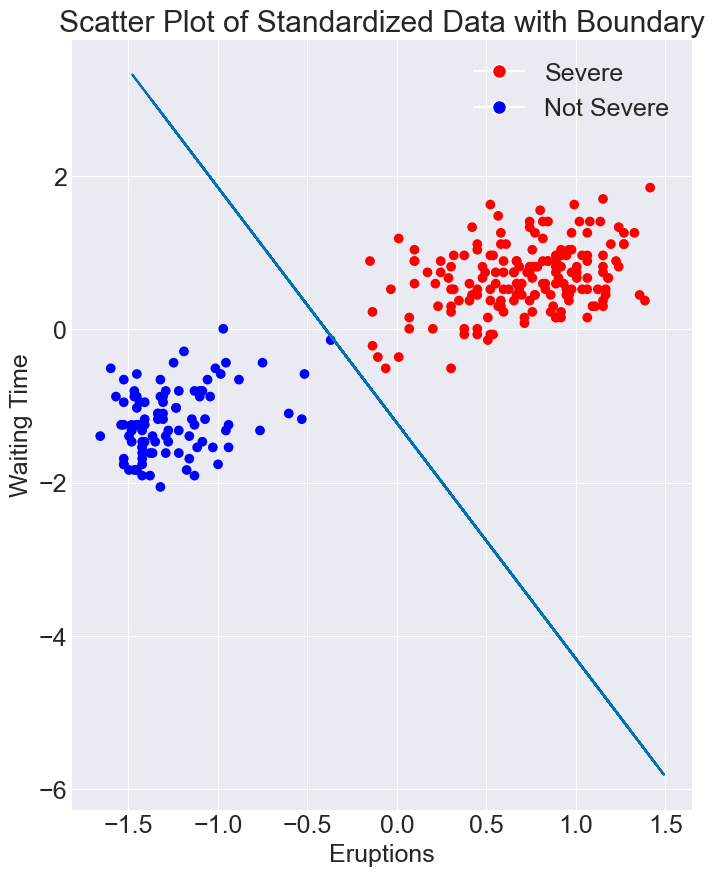

In [10]:
rng = np.random.default_rng()
x_values = rng.uniform(-1.5, 1.5, 50)
y_values = []

for x_i in x_values:
    y_i = m * x_i + b
    y_values.append(y_i)

plt.figure(figsize=(8,10))
plt.title('Class Boundary')
plt.xlabel('Waiting Time')
plt.ylabel('Erruptions')
plt.plot(x_values,y_values)

color_map = np.where(output_classes == 1, 'red', 'blue')
plt.scatter(standardized_features[:, 0], standardized_features[:, 1], c=color_map)
plt.title('Scatter Plot of Standardized Data with Boundary')
plt.xlabel('Eruptions')
plt.ylabel('Waiting Time')

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Severe'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Not Severe')],
           loc='best')
plt.grid(True)

plt.show()


Perceptron: A neural network with a different activation function

$$\text{netAct}_i = f(\text{netIn}_i) = 1  \text{ if netIn}_i \geq 0$$
$$\text{netAct}_i = f(\text{netIn}_i) = -1 \text{ if netIn}_i < 0$$

In [11]:
from adaline import Perceptron

rng = np.random.default_rng(1)
perceptron = Perceptron()
inputs = normalized_features
y = output_classes
loss, acc = perceptron.fit(inputs, y, r_seed=0)


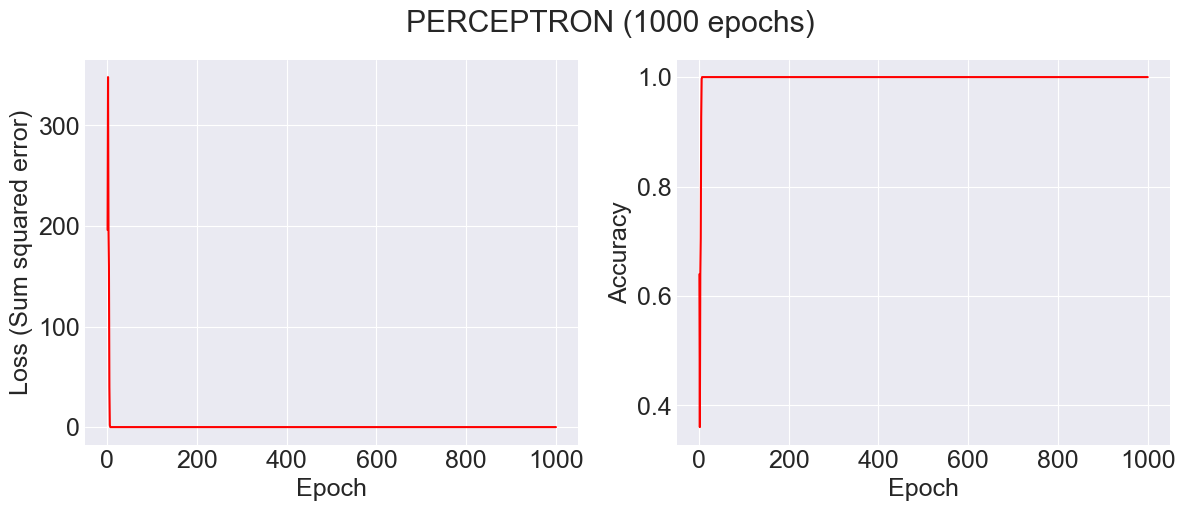

In [12]:
plot_adaline_train(perceptron, loss, acc, title = 'PERCEPTRON')

Comparing performance between ADALINE and Perceptron on Ionosphere dataset

The [Ionosphere dataset](https://archive.ics.uci.edu/dataset/52/ionosphere) is radar signal data collected in Goose Bay, Labrador. It is a more complex dataset than old faithful, with 33 features (but still 2 classes). The class values are coded 'g' for good radar signal and 'b' for bad radar signal.


In [13]:
def plot_nets_train(loss_lists, acc_lists, net_names, plotMarkers=False):
    '''Creates a 1x2 grid of plots showing loss over epochs (left column) and
    accuracy over epochs (right column) for one or more network (num_nets in total).
    Generalizes `plot_adaline_train` for multiple trained networks.

    For example, in the case of two networks (e.g. adaline and perceptron; num_nets=2),
    there would be two curves in each of the two plots.

    Put differently, the following function call would produce the same pair of plots you've
    been getting up until this point with a single adaline network:
        plot_adaline_train(loss_lists[0], acc_lists[0])

    Parameters:
    -----------
    loss_lists: Python lists of ndarrays. len(loss_lists) = num_nets. len(loss_lists[0]) = n_epochs.
        This would be a list of the loss histories for each of the nets being plotted.
    acc_lists: Python lists of ndarrays. len(acc_lists) = num_nets. len(acc_lists[0]) = n_epochs.
        This would be a list of the accuracy histories for each of the nets being plotted.
    net_names: Python list of str. len(net_names) = num_nets.
        Identifying names of each net (e.g. for legend).
    plotMarkers: boolean.
        Should we draw a plot marker at each epoch on each curve?
    '''
    n_nets = len(net_names)
    n_epochs = len(loss_lists[0])

    colors = ['orange', 'blue', 'red']

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    fig.suptitle(f'{n_nets} networks trained for ({n_epochs} epochs)')

    for loss_list, acc_list, color in zip(loss_lists, acc_lists, colors):
        x = np.arange(1, n_epochs+1)

        curveStr = '-'
        if plotMarkers:
            curveStr += 'o'

        ax1.plot(x, loss_list, curveStr, c=color)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (Sum squared error)')
        ax2.plot(x, acc_list, curveStr, c=color)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')

    plt.legend(net_names)
    plt.show()

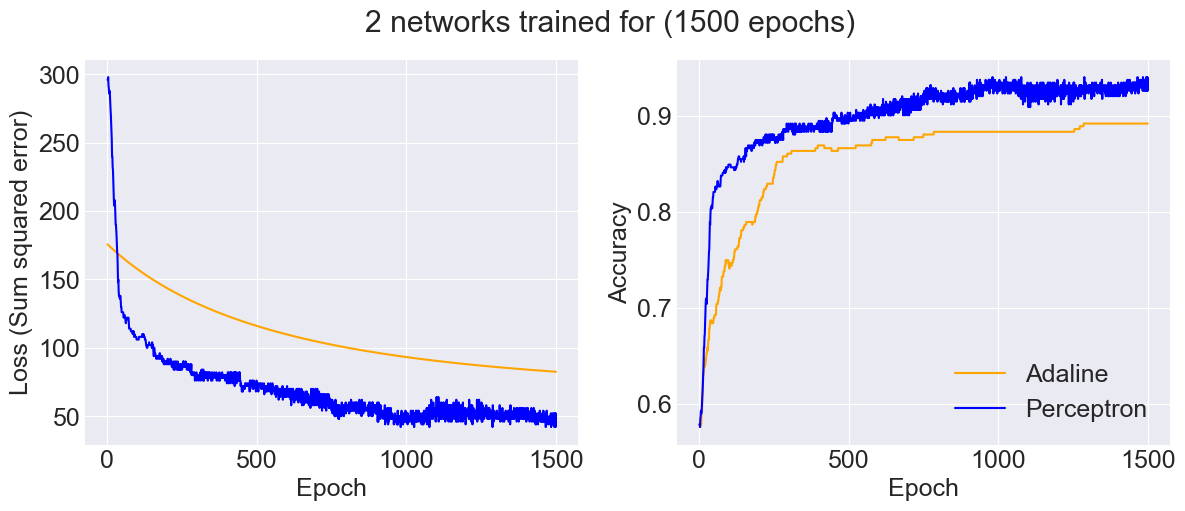

In [14]:
ion_data = pd.read_csv('ionosphere.csv', header=None)
ion_features = ion_data.iloc[:, :-1].values
y = np.where(ion_data.iloc[:, -1] == 'g', 1, -1)

#standardize features
means = ion_features.mean(axis=0)
stdevs = ion_features.std(axis=0)
standardized_ion_features = (ion_features - means) / stdevs

#Adaline
adaline_standardized = Adaline()
adaline_losses, adaline_accs = adaline_standardized.fit(standardized_ion_features, y, lr = 0.000001, n_epochs=1500, r_seed=0)

#Perceptron
perceptron = Perceptron()
perceptron_losses, perceptron_accs = perceptron.fit(standardized_ion_features, y, lr = 0.000001, n_epochs=1500, r_seed=0)

plot_nets_train([adaline_losses, perceptron_losses], [adaline_accs, perceptron_accs], ["Adaline", "Perceptron"])

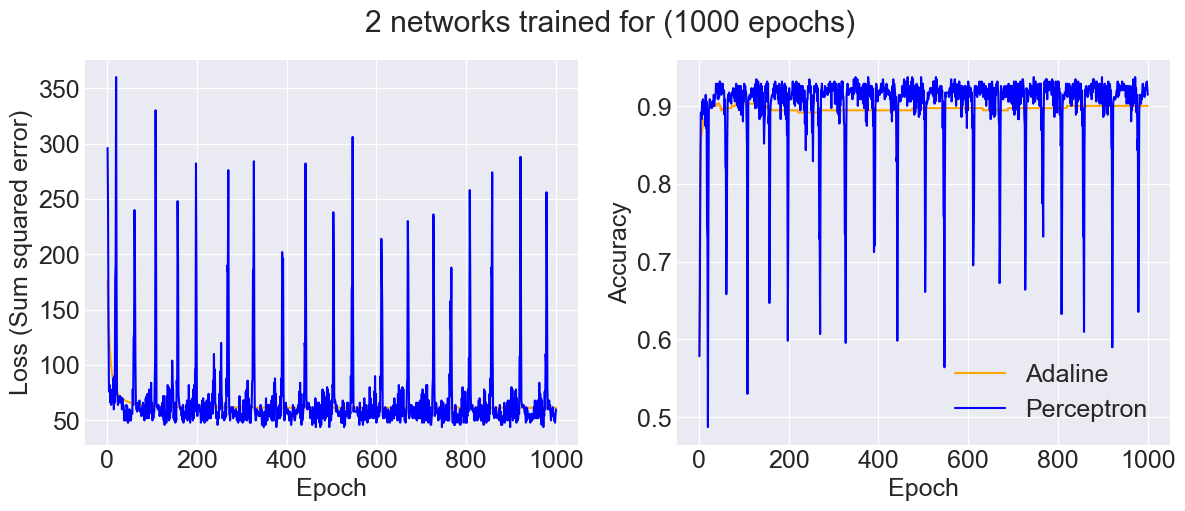

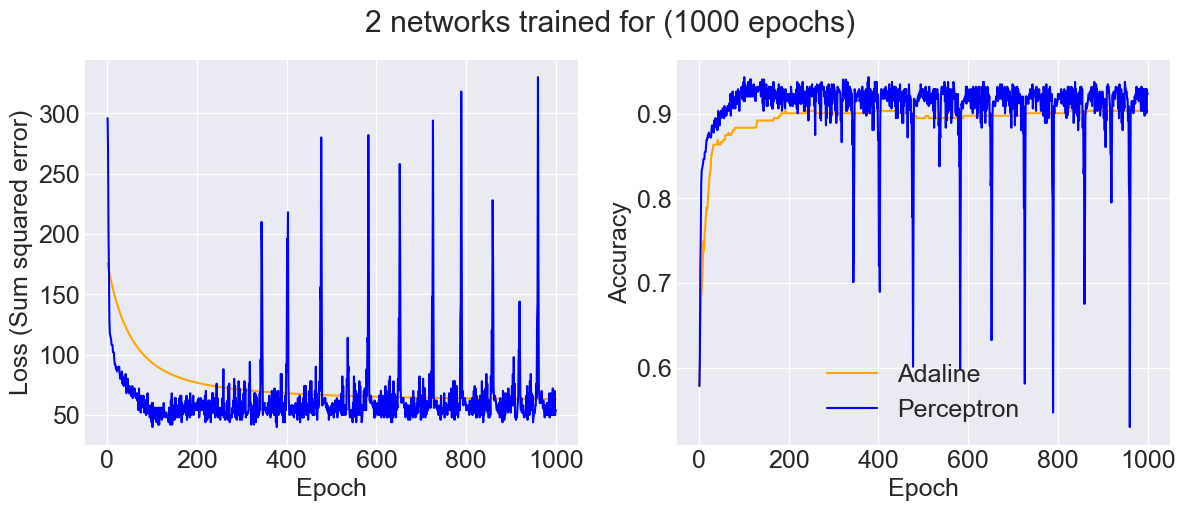

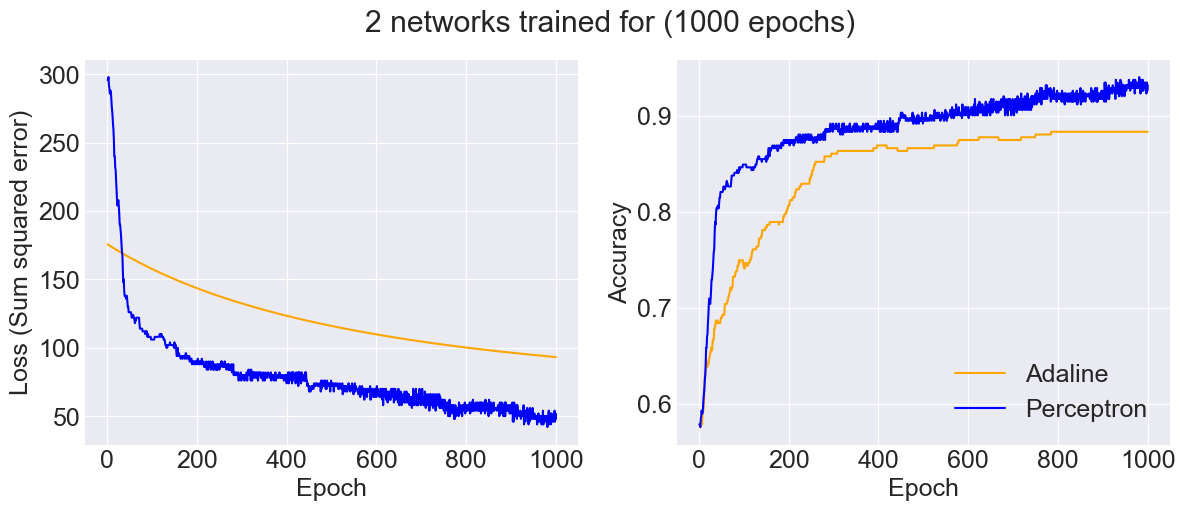

In [15]:
#baseline lr
adaline_losses_baseline, adaline_accs_baseline = adaline_standardized.fit(standardized_ion_features, y, lr = 0.00001, r_seed=0)
perceptron_losses_baseline, perceptron_accs_baseline = perceptron.fit(standardized_ion_features, y, lr = 0.00001, r_seed=0)

#lr increased by an order of magnitude
adaline_losses_increase, adaline_accs_increase = adaline_standardized.fit(standardized_ion_features, y, lr = 0.0001, r_seed=0)
perceptron_losses_increase, perceptron_accs_increase = perceptron.fit(standardized_ion_features, y, lr = 0.0001, r_seed=0)

#lr decreased by an order of magnitude
adaline_losses_decrease, adaline_accs_decrease = adaline_standardized.fit(standardized_ion_features, y, lr = 0.000001, r_seed=0)
perceptron_losses_decrease, perceptron_accs_decrease = perceptron.fit(standardized_ion_features, y, lr = 0.000001, r_seed=0)

plot_nets_train([adaline_losses_increase, perceptron_losses_increase], [adaline_accs_increase, perceptron_accs_increase], ["Adaline", "Perceptron"])
plot_nets_train([adaline_losses_baseline, perceptron_losses_baseline], [adaline_accs_baseline, perceptron_accs_baseline], ["Adaline", "Perceptron"])
plot_nets_train([adaline_losses_decrease, perceptron_losses_decrease], [adaline_accs_decrease, perceptron_accs_decrease], ["Adaline", "Perceptron"])

Compared to the baseline learning rate (middle row), when you increase the learning rate by an order of magnitude (top/first row), we can see that there are more oscillations and more instances where the perceptron network overshoots. The adaline network is pretty stable. On the other hand, when you decrease the learning rate by an order of magnitude (bottom/last row), we can see that there are not as many oscillations and there is a nice, fairly stable curve for both networks. One thing to note is that the perceptron network seems to boast a higher accuracy at the end of training. 

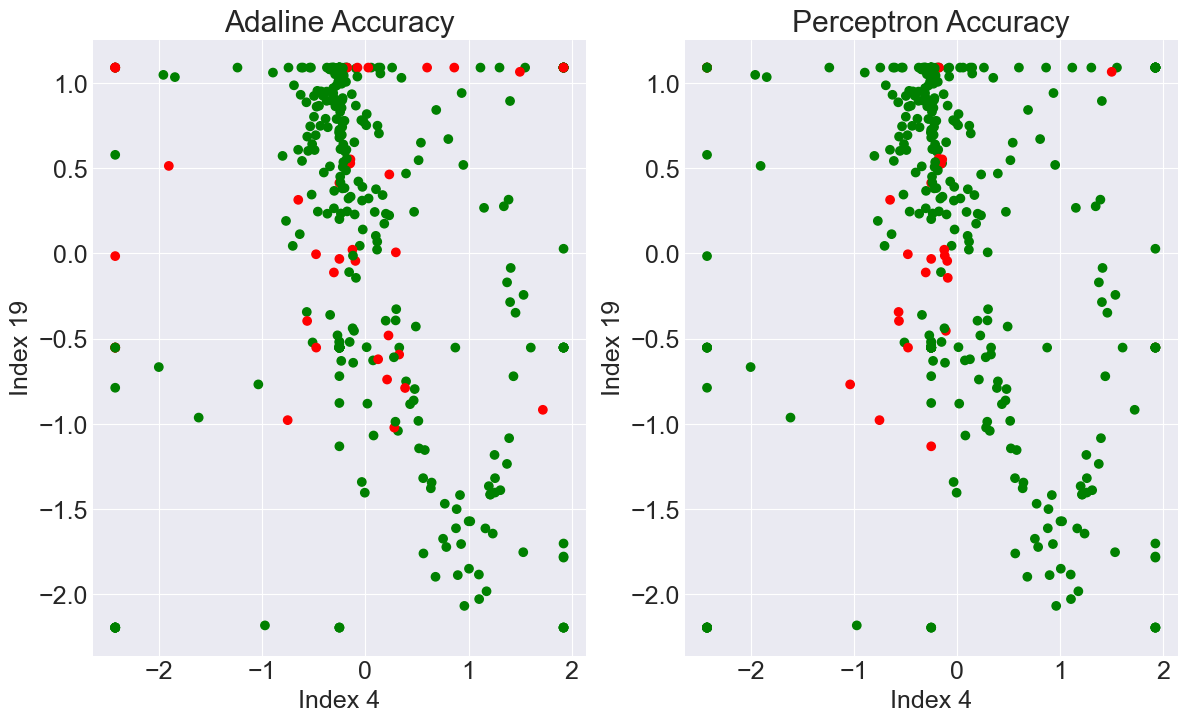

In [16]:
adaline = Adaline()
perceptron = Perceptron()

adaline.fit(standardized_ion_features, y, lr = 0.000001, r_seed=0)
adaline_predicted = adaline.predict(standardized_ion_features)

perceptron.fit(standardized_ion_features, y, lr = 0.000001, r_seed=0)
perceptron_predicted = perceptron.predict(standardized_ion_features)

#color coding 
adaline_colors = np.where(adaline_predicted == y, 'green', 'red')
perceptron_colors = np.where(perceptron_predicted == y, 'green', 'red')

#plot scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].scatter(standardized_ion_features[:, 4], standardized_ion_features[:, 19], c=adaline_colors, label="Adaline")
axes[1].scatter(standardized_ion_features[:, 4], standardized_ion_features[:, 19], c=perceptron_colors, label="Perceptron")

#titles
axes[0].set_title('Adaline Accuracy')
axes[1].set_title('Perceptron Accuracy')

#axis labels
axes[0].set_xlabel('Index 4')
axes[0].set_ylabel('Index 19')
axes[1].set_xlabel('Index 4')
axes[1].set_ylabel('Index 19')

plt.show()


It is possible that misclassifications are dispersed and do not appear on either side of a simple boundary because the dataset may have a non-linear relationship between features, which would then require a more complex decision boundary than a simple line. Since perceptron and ADALINE rely on a linear model, it is likely that they can't handle decision boundary that is more complex than a simple line or hyperplane. 